# Steel Industry Energy Consumption - Model Training with Metrics

This notebook demonstrates the training process for our energy consumption prediction model with detailed accuracy metrics.

In [8]:
import sys
import os
sys.path.append('../src')

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from steel_energy_opt.data_processor import DataProcessor
from steel_energy_opt.model import EnergyPredictor, ModelTrainer

## 1. Load and Preprocess Data

In [9]:
# Initialize data processor
processor = DataProcessor()

# Load and preprocess data
data_path = '../data/raw/Steel_industry_data.csv'
df = processor.load_data(data_path)
df = processor.preprocess_data(df)

# Display basic information about the dataset
print("Dataset Info:")
print(df.info())
print("\nSample Data:")
print(df.head())

INFO:steel_energy_opt.data_processor:Successfully loaded data from ../data/raw/Steel_industry_data.csv


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 14 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   date                                  35040 non-null  datetime64[ns]
 1   Usage_kWh                             35040 non-null  float64       
 2   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64       
 3   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64       
 4   CO2(tCO2)                             35040 non-null  float64       
 5   Lagging_Current_Power_Factor          35040 non-null  float64       
 6   Leading_Current_Power_Factor          35040 non-null  float64       
 7   NSM                                   35040 non-null  int64         
 8   WeekStatus                            35040 non-null  int64         
 9   Day_of_week                           35040 non-null  obje

## 2. Prepare Features and Split Data

In [10]:
# Prepare features
X, y = processor.prepare_features(df)

# Split data
data_splits = processor.split_data(X, y)

# Convert to PyTorch tensors
X_train = torch.FloatTensor(data_splits['X_train'])
y_train = torch.FloatTensor(data_splits['y_train'])
X_val = torch.FloatTensor(data_splits['X_val'])
y_val = torch.FloatTensor(data_splits['y_val'])
X_test = torch.FloatTensor(data_splits['X_test'])
y_test = torch.FloatTensor(data_splits['y_test'])

print(f"Training set size: {X_train.shape}")
print(f"Validation set size: {X_val.shape}")
print(f"Test set size: {X_test.shape}")

Training set size: torch.Size([25228, 8])
Validation set size: torch.Size([2804, 8])
Test set size: torch.Size([7008, 8])


## 3. Initialize and Train Model

In [11]:
# Initialize model
input_size = X_train.shape[1]
model = EnergyPredictor(input_size=input_size)
trainer = ModelTrainer(model)

# Train model
history = trainer.train(
    train_data=(X_train, y_train),
    val_data=(X_val, y_val),
    epochs=10000,
    early_stopping_patience=20
)

INFO:steel_energy_opt.model:Early stopping triggered at epoch 1018

raining:  10%|█         | 1017/10000 [00:25<03:40, 40.65it/s, train_mse=130.5440, val_mse=61.8733, train_r2=0.8885, val_mape=34.31%]

## 4. Visualize Training Results

Final Metrics:
Training R² Score: 0.8885
Validation R² Score: 0.9341
Training MAPE: 52.47%
Validation MAPE: 34.31%


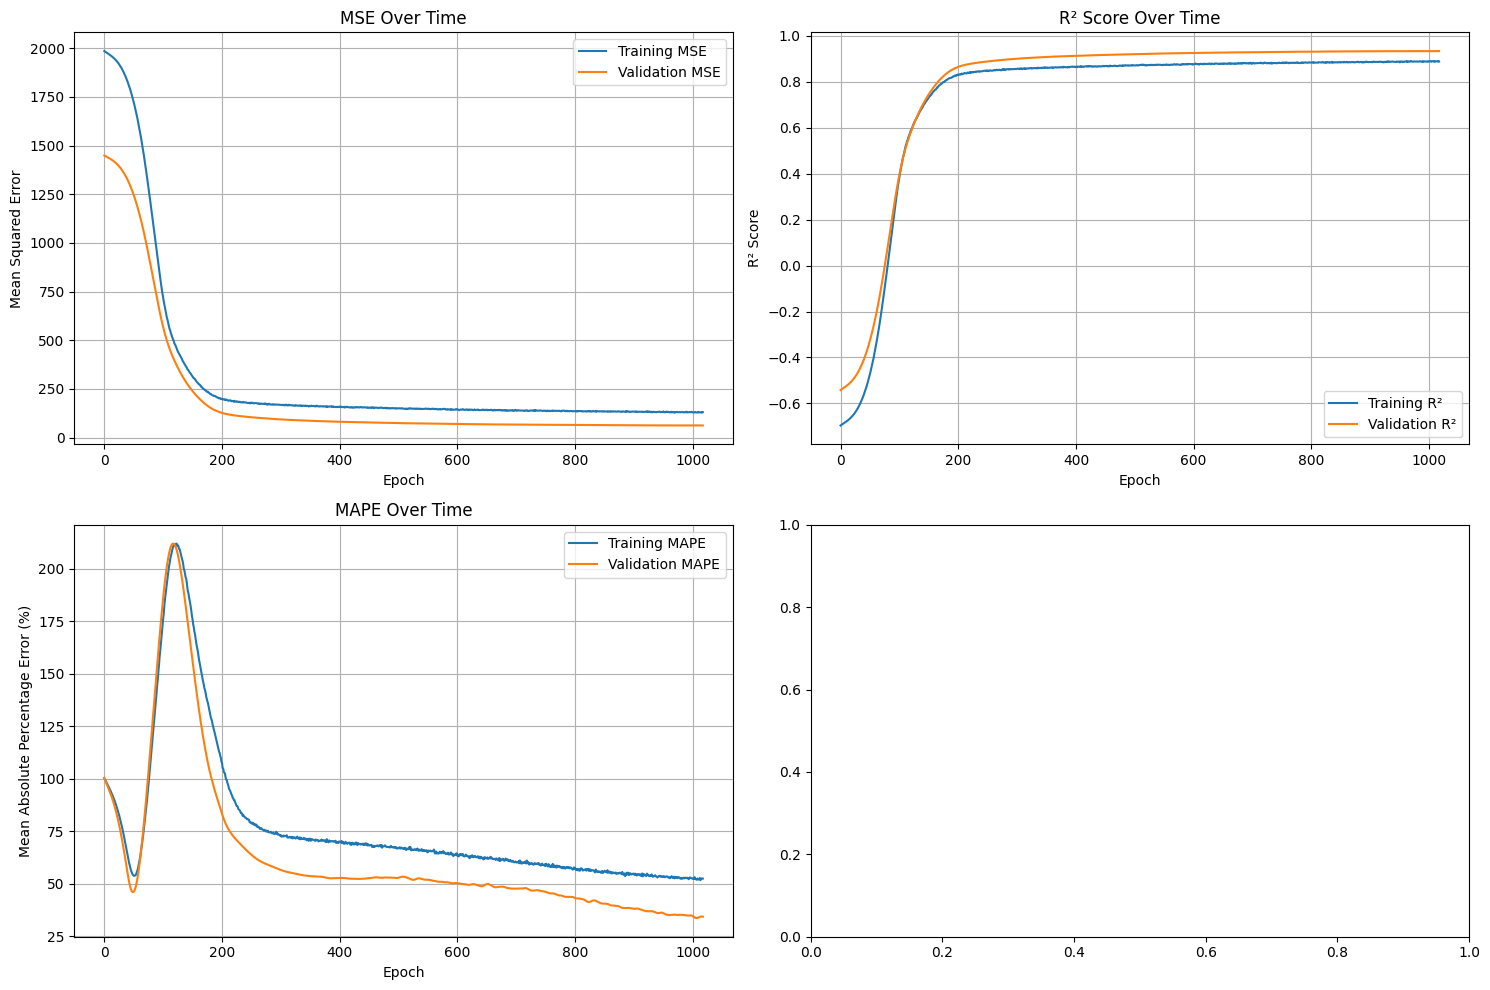

In [12]:
# Plot training metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot MSE
axes[0,0].plot(history['train_mse'], label='Training MSE')
axes[0,0].plot(history['val_mse'], label='Validation MSE')
axes[0,0].set_xlabel('Epoch')
axes[0,0].set_ylabel('Mean Squared Error')
axes[0,0].set_title('MSE Over Time')
axes[0,0].legend()
axes[0,0].grid(True)

# Plot R² Score
axes[0,1].plot(history['train_r2'], label='Training R²')
axes[0,1].plot(history['val_r2'], label='Validation R²')
axes[0,1].set_xlabel('Epoch')
axes[0,1].set_ylabel('R² Score')
axes[0,1].set_title('R² Score Over Time')
axes[0,1].legend()
axes[0,1].grid(True)

# Plot MAPE
axes[1,0].plot(history['train_mape'], label='Training MAPE')
axes[1,0].plot(history['val_mape'], label='Validation MAPE')
axes[1,0].set_xlabel('Epoch')
axes[1,0].set_ylabel('Mean Absolute Percentage Error (%)')
axes[1,0].set_title('MAPE Over Time')
axes[1,0].legend()
axes[1,0].grid(True)

# Print final metrics
print("Final Metrics:")
print(f"Training R² Score: {history['train_r2'][-1]:.4f}")
print(f"Validation R² Score: {history['val_r2'][-1]:.4f}")
print(f"Training MAPE: {history['train_mape'][-1]:.2f}%")
print(f"Validation MAPE: {history['val_mape'][-1]:.2f}%")

plt.tight_layout()
plt.show()

## 5. Evaluate Model on Test Set

Test Set Performance:
R² Score: 0.8542
Mean Absolute Percentage Error: 59535058534400.00%
Mean Squared Error: 143.5223


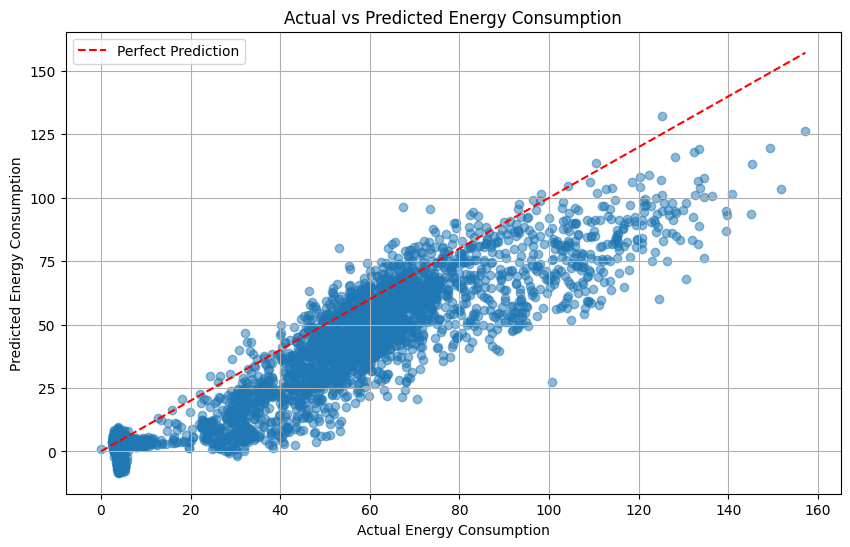

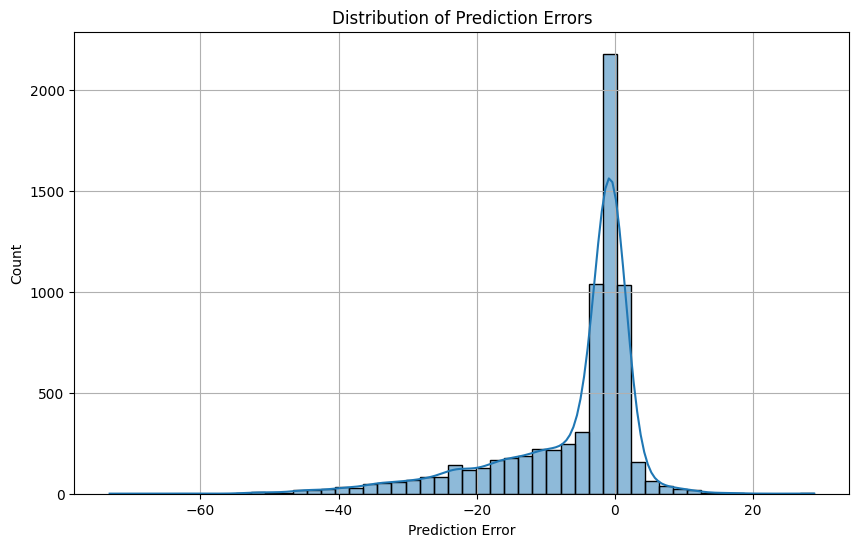

In [13]:
# Get predictions and metrics on test set
test_metrics = trainer.validate(X_test, y_test)
test_predictions = trainer.predict(X_test).squeeze()

print("Test Set Performance:")
print(f"R² Score: {test_metrics['r2_score']:.4f}")
print(f"Mean Absolute Percentage Error: {test_metrics['mape']:.2f}%")
print(f"Mean Squared Error: {test_metrics['mse']:.4f}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test.numpy(), test_predictions.numpy(), alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Energy Consumption')
plt.ylabel('Predicted Energy Consumption')
plt.title('Actual vs Predicted Energy Consumption')
plt.legend()
plt.grid(True)
plt.show()

# Plot prediction error distribution
errors = (test_predictions.numpy() - y_test.numpy())
plt.figure(figsize=(10, 6))
sns.histplot(errors, bins=50, kde=True)
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.title('Distribution of Prediction Errors')
plt.grid(True)
plt.show()

## 6. Save Model

In [14]:
# Save the trained model
from datetime import datetime
import os

save_dir = '../models'
os.makedirs(save_dir, exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
save_path = os.path.join(save_dir, f"model_{timestamp}.pt")

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': trainer.optimizer.state_dict(),
    'history': history,
    'test_metrics': test_metrics
}, save_path)

print(f"Model saved to {save_path}")

Model saved to ../models/model_20241215_175359.pt
